In [1]:
#Import packages
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as k
from keras import models
from keras import layers
from keras.models import load_model
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
import copy
import numpy as np
%matplotlib notebook

Using TensorFlow backend.


# MNIST Inverted grayscale explanation

In This notebook I try to explain how a convolutional neural network deals with inverted grayscale. With Inverted Grayscale I mean that the grayscale is flipped totally. (0 becomes 255, 255 becomes 0).

## Datasets
The dataset used is the MNIST dataset (X_train, X_test, y_train, y_test).
The dataset is inverted (X_train_inverted, X_test_inverted, y_train, y_test).
There is also a mixed dataset (X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed)

## Models
In the mian chapter (5), three models are built:
- P: trained on the MNIST dataset (A)
- Q: trained on the MNIST inverted dataset (B)
- R: trained on the MNIST Mixed dataset (C)

## Index Jupyter notebook
1. Basic model
2. Invert the color 
3. Mixed data set
4. Visualization
5. Main
    1. Model P
    2. Model Q
    3. Model R

## 1. Basic Model

In [2]:
def initiate_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    #print('Summary of the model:')
    #model.summary()
    return model

In [3]:
def load_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    return X_train, y_train, X_test, y_test

In [4]:
def transform_data(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape((60000, 28, 28, 1))
    X_train = X_train.astype('float32') / 255
    X_test = X_test.reshape((10000, 28, 28, 1))
    X_test = X_test.astype('float32') / 255
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, y_train, X_test, y_test

In [5]:
def get_model(X_train, y_train):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64) #EPOCH=5
    with open('output\output.txt', 'w') as file:
        model.summary(print_fn=lambda x: file.write(x + '\n'))
        file.write('\n')
        file.write('epoch: 5 \n')
        file.write('batch_size: 64 \n')
        file.write('\n')
    return model

In [6]:
def print_model():
    with open('output\model.txt', 'w') as file:
        model.summary(print_fn=lambda x: file.write(x + '\n'))
        file.write('\n')
        file.write('epoch: 5 \n')
        file.write('batch_size: 64 \n')
        file.write('\n')

In [8]:
def get_metrics(X_test, y_test, file_name):
    output_file='output\ '+file_name+'.txt' 
    with open(output_file, 'a+') as file:  # Use file to refer to the file object
        #X_test_transformed, y_test
        # predict probabilities for test set
        yhat_probs = model.predict(X_test, verbose=0)
        # predict crisp classes for test set
        yhat_classes = model.predict_classes(X_test, verbose=0)

        # accuracy: (tp + tn) / (p + n)
        accuracy = metrics.accuracy_score(y_test, yhat_classes)
        print('Accuracy: %f' % accuracy )
        file.write('Accuracy: %f \n' % accuracy)
        #precision tp / (tp + fp)
        precision = metrics.precision_score(y_test, yhat_classes, average='weighted')
        print('Precision: %f' % precision)
        file.write('Precision: %f \n' % precision)
        #recall: tp / (tp + fn)
        recall = metrics.recall_score(y_test, yhat_classes, average='weighted')
        print('Recall: %f' % recall)
        file.write('Recall: %f \n' % recall)
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = metrics.f1_score(y_test, yhat_classes, average='weighted')
        print('F1 score: %f' % f1)
        file.write('F1 score: %f \n' % f1)

        # kappa
        kappa = metrics.cohen_kappa_score(y_test, yhat_classes)
        print('Cohens kappa: %f' % kappa)
        file.write('Cohens kappa: %f \n' % kappa)
        # confusion matrix
        matrix = metrics.confusion_matrix(y_test, yhat_classes)
        print('Confusion matrix:')
        file.write('Confusion matrix: \n')
        print(matrix)
        file.write(str(matrix))

## 2. Invert Color
### 2.1 Invert Color item

In [9]:
def invert_color(index):
    inverted= copy.deepcopy(index)
    for horizontal in range(len(inverted)):
        for index1 in range(len(inverted[horizontal])):
            inverted[horizontal][index1]=255-inverted[horizontal][index1]
    return inverted

### 2.2 Invert Color sets

In [12]:
def invert_color_set(X_train, X_test):
#Invert the color of the whole set X_train_base
    X_train_inverted=[]
    for index, item in enumerate(X_train):
        X_train_inverted.append(invert_color(item))
    X_train_inverted=np.asarray(X_train_inverted)
    
    X_test_inverted=[]
    for index, item in enumerate(X_test):
        X_test_inverted.append(invert_color(item))
    X_test_inverted=np.asarray(X_test_inverted)
    return X_train_inverted, X_test_inverted

In [13]:
def export_3D_array(X_set, label):
# Write the array to disk
    with open(label+'.txt', 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# Array shape: {0}\n'.format(X_set.shape))

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in X_set:

            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places.  
            np.savetxt(outfile, data_slice, fmt='%-7.2f')

            # Writing out a break to indicate different slices...
            outfile.write('# New slice\n')

In [14]:
#Initially invert the color. Next time just import it from the folder

#X_train_inverted, X_test_inverted = invert_color_set(X_train, X_test)
#export_3D_array(X_train_inverted, 'X_train_inverted')
#export_3D_array(X_test_inverted, 'X_test_inverted')

In [15]:
def import_3D_array():
    X_train_inverted = np.loadtxt('X_train_inverted.txt')
    #transformation is already done in def transform
    #X_train_inverted=X_train_inverted.reshape(60000, 28, 28, 1)
    X_test_inverted = np.loadtxt('X_test_inverted.txt')
    #X_test_inverted=X_test_inverted.reshape(10000, 28, 28, 1)
    return X_train_inverted, X_test_inverted

# 3. Mixed data set

In [16]:
def create_mixed_train_set():
    number_cases=60000 #check amount
    X_train_index_done=[]
    X_train_inversed_index_done=[]
    X_train_mixed=[]
    y_train_mixed=[]
    #transformed
    while len(X_train_mixed)<number_cases/2: #check amount
        new_value=np.random.randint(number_cases) #check amount
        if new_value not in X_train_index_done:
            X_train_index_done.append(new_value)
            X_train_mixed.append(X_train_transformed[new_value])
            y_train_mixed.append(y_train[new_value])
    #inversed
    while len(X_train_mixed)<number_cases: #check amount
        new_value=np.random.randint(number_cases) #check amount
        if new_value not in X_train_inversed_index_done:
            X_train_inversed_index_done.append(new_value)
            X_train_mixed.append(X_train_inverted_transformed[new_value])
            y_train_mixed.append(y_train[new_value])
    X_train_mixed=np.asarray(X_train_mixed)
    y_train_mixed=np.asarray(y_train_mixed)
    return X_train_mixed, y_train_mixed

In [17]:
def create_mixed_test_set():
    number_cases=10000 #check amount
    X_test_index_done=[]
    X_test_inversed_index_done=[]
    X_test_mixed=[]
    y_test_mixed=[]
    #transformed
    while len(X_test_mixed)<number_cases/2: #check amount
        new_value=np.random.randint(number_cases) #check amount
        if new_value not in X_test_index_done:
            X_test_index_done.append(new_value)
            X_test_mixed.append(X_test_transformed[new_value])
            y_test_mixed.append(y_test[new_value])
    #inversed
    while len(X_test_mixed)<number_cases: #check amount
        new_value=np.random.randint(number_cases) #check amount
        if new_value not in X_test_inversed_index_done:
            X_test_inversed_index_done.append(new_value)
            X_test_mixed.append(X_test_inverted_transformed[new_value])
            y_test_mixed.append(y_test[new_value])
    X_test_mixed=np.asarray(X_test_mixed)
    y_test_mixed=np.asarray(y_test_mixed)
    return X_test_mixed, y_test_mixed

# 4. Visualization

In [37]:
# plot 2 different images in black and white
def plot_images(index):
    export='blackandwhite.'+str(index)+'.png'
    #Remove one dimension to create a print
    x = X_test_transformed
    result = x[:, :, :,0]
    X_test_print=result
    plt.subplot(121)
    plt.imshow(X_test_print[index], cmap=plt.get_cmap('gray'))
    plt.subplot(122)
    plt.imshow(invert_color(X_test_print[index]), cmap=plt.get_cmap('gray'))
    plt.savefig(export)

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:5]]

In [ ]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(X_test_mixed[:15]) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
plt.matshow(first_layer_activation[6,:, :, 1], cmap='viridis')

In [18]:
def visualize(index, set_name, name_of_test, name_of_train):
    layer_outputs = [layer.output for layer in model.layers[:5]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
    activations = activation_model.predict(set_name[:15]) 
    
    layer_names = []
    for layer in model.layers[:5]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[index,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.colorbar()
        name=str(name_of_train)+'.'+str(name_of_test)+'.'+str(index)+'.'+str(layer_name)+'.png'
        print(name)
        plt.savefig('output/'+name)

In [26]:
def find_number():
    for index, number in enumerate(X_test_mixed):
        if (number == X_test_transformed[0]).all():
            return index
        if (number == X_test_inverted_transformed[0]).all():
            return index
    return 0 

# MAIN 

## Import datasets

In [21]:
#A MNIST
#load the data
X_train, y_train, X_test, y_test = load_data()
#transform data
X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed=transform_data(X_train, y_train, X_test, y_test)

#B MNIST INVERTED
#Import inverted dataset
X_train_inverted, X_test_inverted=import_3D_array()
#transform inverted set
X_train_inverted_transformed, y_train_transformed, X_test_inverted_transformed, y_test_transformed=transform_data(X_train_inverted, y_train, X_test_inverted, y_test)

#C MNIST MIXED
X_train_mixed, y_train_mixed = create_mixed_train_set()
X_test_mixed, y_test_mixed = create_mixed_test_set()

#X datasets are already transformed
#Transform y_sets
y_train_mixed_transformed = to_categorical(y_train_mixed)
y_test_mixed_transformed = to_categorical(y_test_mixed)

## MODEL P 

Epoch 1/5
60000/60000 [==============================] - 47s 779us/step - loss: 0.1657 - acc: 0.9482
Epoch 2/5
60000/60000 [==============================] - 45s 754us/step - loss: 0.0467 - acc: 0.9852
Epoch 3/5
60000/60000 [==============================] - 44s 740us/step - loss: 0.0334 - acc: 0.9894
Epoch 4/5
60000/60000 [==============================] - 44s 740us/step - loss: 0.0249 - acc: 0.9923
Epoch 5/5
60000/60000 [==============================] - 45s 750us/step - loss: 0.0193 - acc: 0.9946
Accuracy: 0.992000
Precision: 0.992041
Recall: 0.992000
F1 score: 0.991997
Cohens kappa: 0.991107
Confusion matrix:
[[ 976    1    1    0    0    0    0    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    1 1025    0    0    0    0    5    0    0]
 [   0    0    1 1004    0    3    0    2    0    0]
 [   0    0    0    0  978    0    0    1    0    3]
 [   0    0    0    5    0  884    1    1    0    1]
 [   5    6    0    0    2    4  940    0    1    0]
 [   0  

c:\users\s149613\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


X_train.X_test.0.max_pooling2d_4.png
X_train.X_test.0.conv2d_6.png
X_train.X_test_inverted.0.conv2d_4.png
X_train.X_test_inverted.0.max_pooling2d_3.png
X_train.X_test_inverted.0.conv2d_5.png
X_train.X_test_inverted.0.max_pooling2d_4.png
X_train.X_test_inverted.0.conv2d_6.png


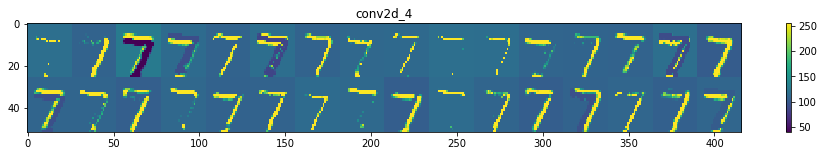

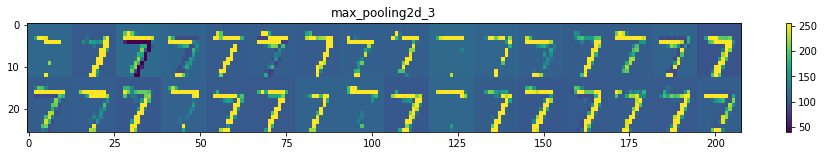

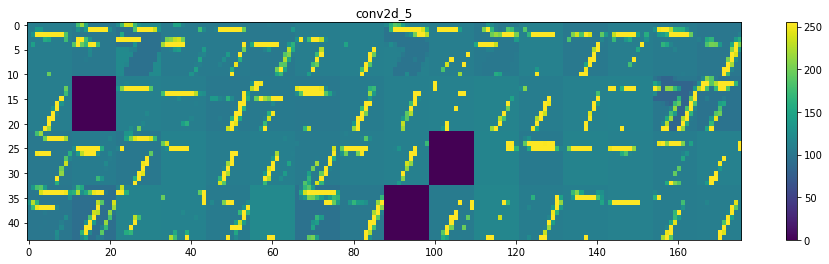

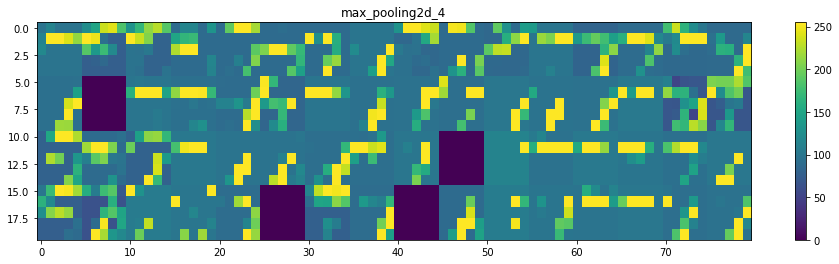

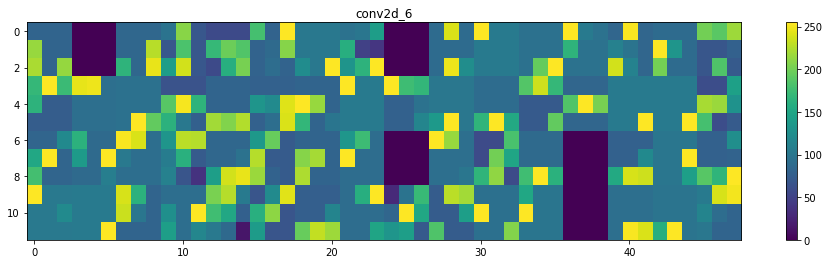

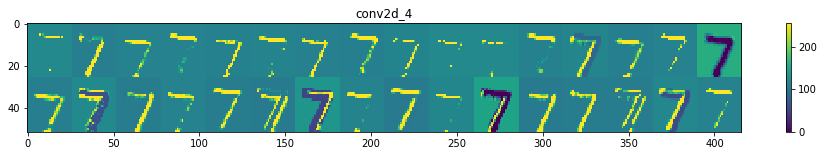

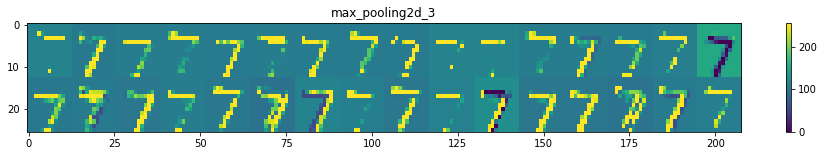

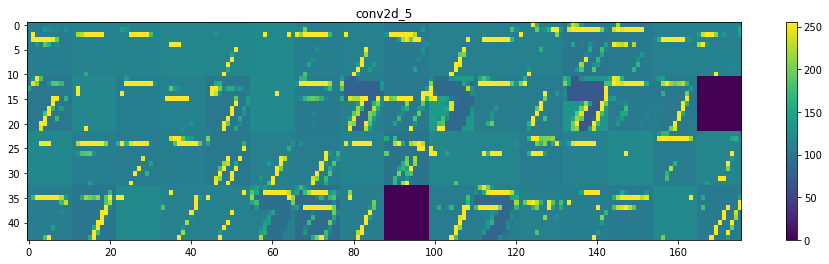

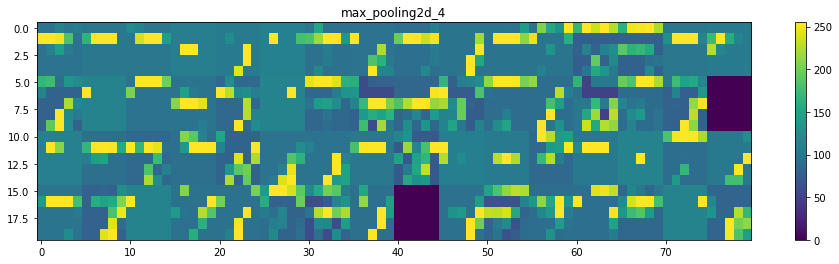

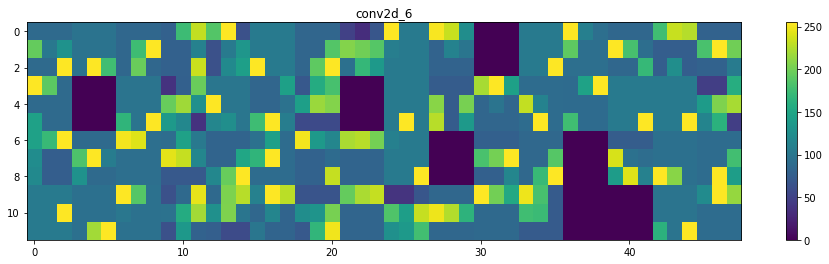

In [22]:
#initiate model
model = initiate_model()
#print the model to output file
print_model()
#create model
model = get_model(X_train_transformed, y_train_transformed)
#Save the model
model.save('models\X_train.h5')
#Get metrics result i
get_metrics(X_test_transformed, y_test, 'evaluation.X_train.X_test')
#Get metrics result ii
get_metrics(X_test_inverted_transformed, y_test, 'evaluation.X_train.X_test_inverted')
#export visualizations i
visualize(0,X_test_transformed, 'X_test', 'X_train')
#export visualization ii
visualize(0,X_test_inverted_transformed, 'X_test_inverted', 'X_train')

## MODEL Q -  TODO

Epoch 1/5
60000/60000 [==============================] - 39s 648us/step - loss: 0.2125 - acc: 0.9333
Epoch 2/5
60000/60000 [==============================] - 38s 631us/step - loss: 0.0494 - acc: 0.9847
Epoch 3/5
60000/60000 [==============================] - 38s 635us/step - loss: 0.0346 - acc: 0.9892
Epoch 4/5
60000/60000 [==============================] - 39s 649us/step - loss: 0.0263 - acc: 0.9922
Epoch 5/5
60000/60000 [==============================] - 39s 648us/step - loss: 0.0209 - acc: 0.9934
Accuracy: 0.993300
Precision: 0.993316
Recall: 0.993300
F1 score: 0.993299
Cohens kappa: 0.992553
Confusion matrix:
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1133    0    1    0    1    0    0    0    0]
 [   1    1 1026    0    0    0    0    4    0    0]
 [   0    0    1 1006    0    2    0    0    0    1]
 [   0    1    0    0  970    0    4    0    0    7]
 [   2    0    0    6    0  883    1    0    0    0]
 [   2    1    0    0    1    1  952    0    1    0]
 [   0  

c:\users\s149613\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


X_train_inverted.X_test_inverted.0.max_pooling2d_9.png
X_train_inverted.X_test_inverted.0.conv2d_14.png
X_train_inverted.X_test_inverted.0.max_pooling2d_10.png
X_train_inverted.X_test_inverted.0.conv2d_15.png
X_train_inverted.X_test.0.conv2d_13.png
X_train_inverted.X_test.0.max_pooling2d_9.png
X_train_inverted.X_test.0.conv2d_14.png
X_train_inverted.X_test.0.max_pooling2d_10.png
X_train_inverted.X_test.0.conv2d_15.png


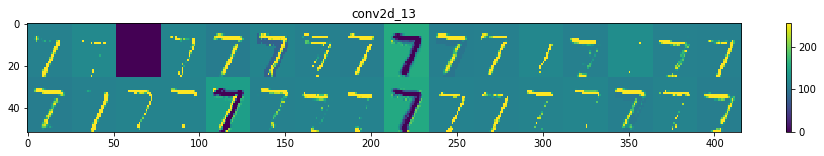

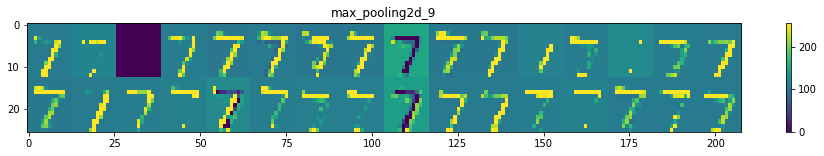

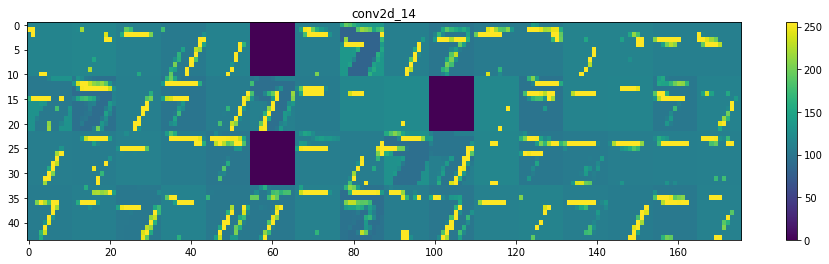

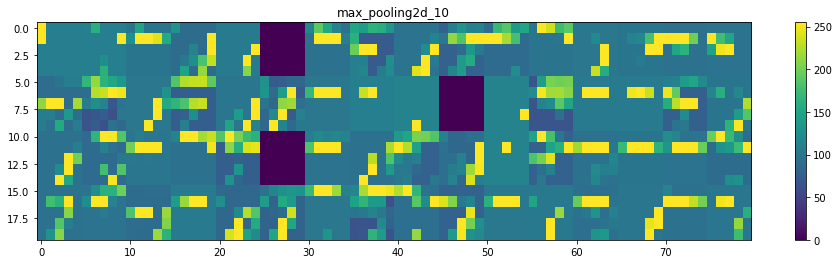

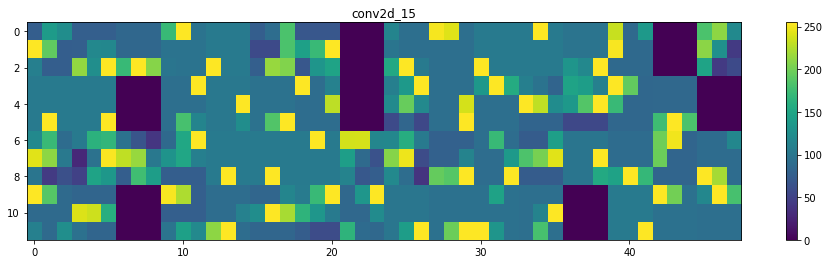

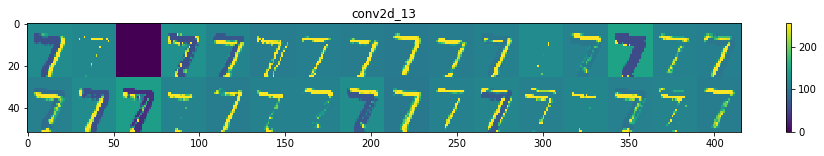

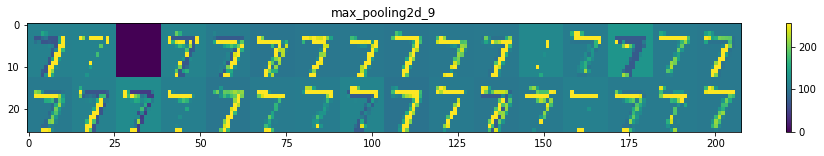

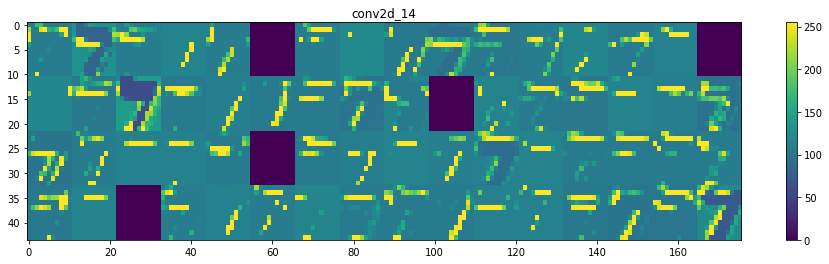

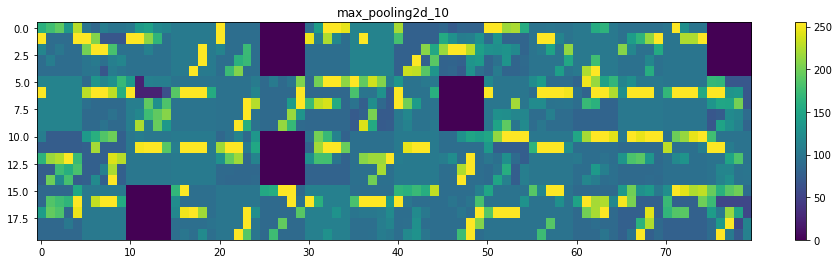

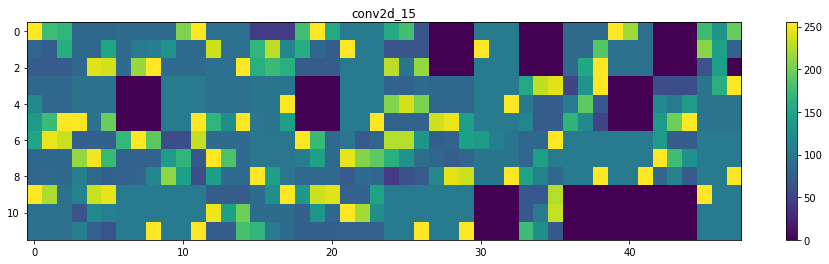

In [24]:
#initiate model
model = initiate_model()
#print the model to output file
print_model()
#create model
model = get_model(X_train_inverted_transformed, y_train_transformed)
#Save the model
model.save('models\X_train_inverted.h5')
#Get metrics result iii
get_metrics(X_test_inverted_transformed, y_test, 'evaluation.X_train_inverted.X_test')
#Get metrics result iv
get_metrics(X_test_transformed, y_test, 'evaluation.X_train_inverted.X_test_inverted')
#export visualizations iii
visualize(0,X_test_inverted_transformed, 'X_test_inverted', 'X_train_inverted')
#export visualization iiv
visualize(0,X_test_transformed, 'X_test', 'X_train_inverted')

In [25]:
get_metrics(X_test_transformed, y_test, 'evaluation.X_train_inverted.X_test_inverted')

Accuracy: 0.432400
Precision: 0.481954
Recall: 0.432400
F1 score: 0.409163
Cohens kappa: 0.369924
Confusion matrix:
[[301  32   1 180   0  37 257   0   2 170]
 [358 609   5   0   4   0  36 120   3   0]
 [274  45 437  76   1  50   2   7  25 115]
 [120   0  83 134   1 322 134   4 136  76]
 [138  73 132  68  14 219  93   5  86 154]
 [  9   1  12  30   0 638 115   1  65  21]
 [221   0   0  21   0  88 617   0  10   1]
 [ 48 205 164   3   0  31   2 424  42 109]
 [140   2  70  15   0 142 104  16 416  69]
 [ 78   1  61  27   0  17   4   2  85 734]]


## MODEL R

Epoch 1/5
60000/60000 [==============================] - 44s 733us/step - loss: 0.2384 - acc: 0.9247
Epoch 2/5
60000/60000 [==============================] - 37s 623us/step - loss: 0.0550 - acc: 0.9824
Epoch 3/5
60000/60000 [==============================] - 41s 689us/step - loss: 0.0376 - acc: 0.9880
Epoch 4/5
60000/60000 [==============================] - 40s 666us/step - loss: 0.0278 - acc: 0.9909
Epoch 5/5
60000/60000 [==============================] - 43s 709us/step - loss: 0.0221 - acc: 0.9934
Accuracy: 0.984900
Precision: 0.985116
Recall: 0.984900
F1 score: 0.984897
Cohens kappa: 0.983215
Confusion matrix:
[[ 963    0    0    0    0    3   12    0    2    0]
 [   1 1132    0    3    0    1    1    0    0    0]
 [   1    6 1039    1    0    0    1    3    2    0]
 [   0    0    0 1011    0    8    0    1    1    0]
 [   0    0    0    0  971    0    2    0    0    1]
 [   0    0    0    3    0  890    1    0    1    0]
 [   0    5    0    0    1    4  926    0    2    0]
 [   0  

c:\users\s149613\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


X_train_mixed.X_test.0.max_pooling2d_18.png
X_train_mixed.X_test.0.conv2d_27.png
X_train_mixed.X_test_inverted.0.conv2d_25.png
X_train_mixed.X_test_inverted.0.max_pooling2d_17.png
X_train_mixed.X_test_inverted.0.conv2d_26.png
X_train_mixed.X_test_inverted.0.max_pooling2d_18.png
X_train_mixed.X_test_inverted.0.conv2d_27.png


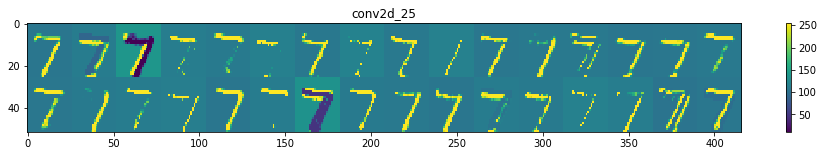

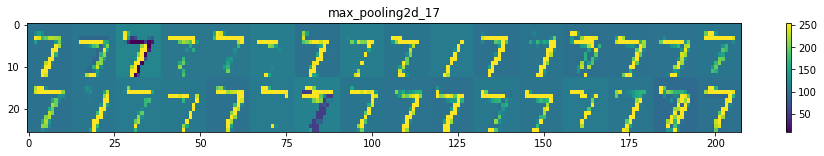

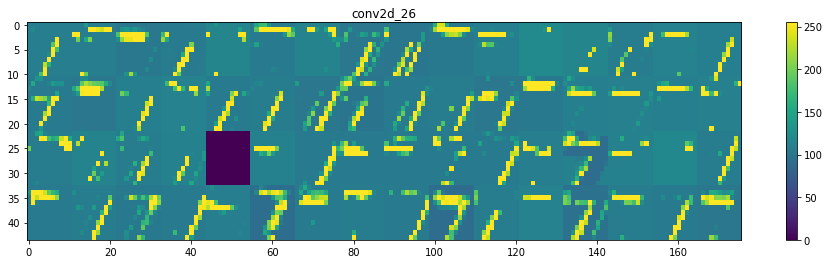

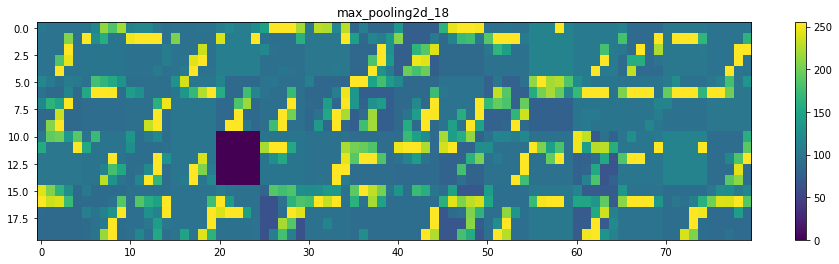

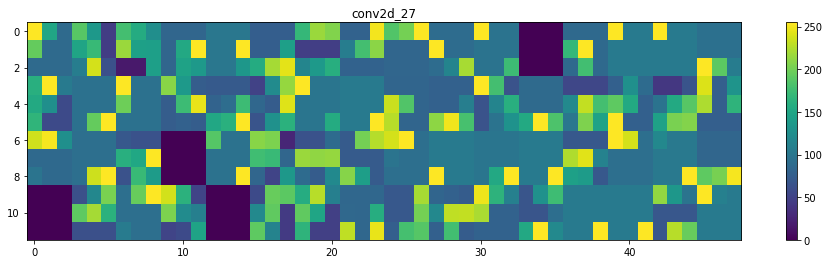

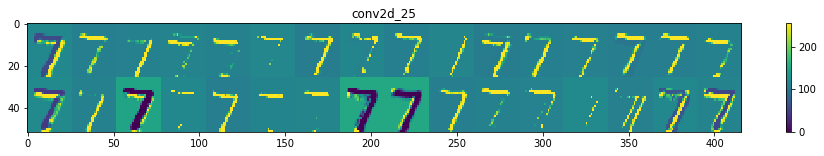

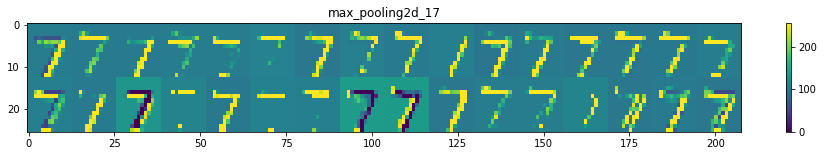

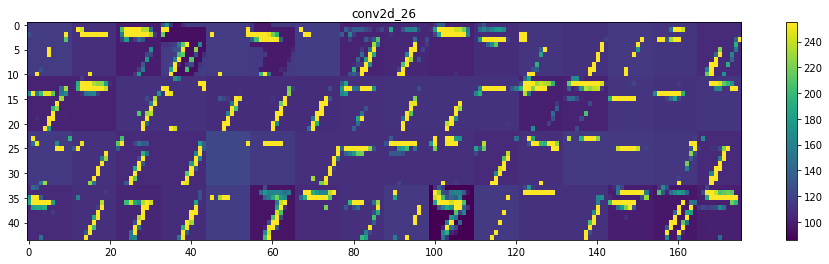

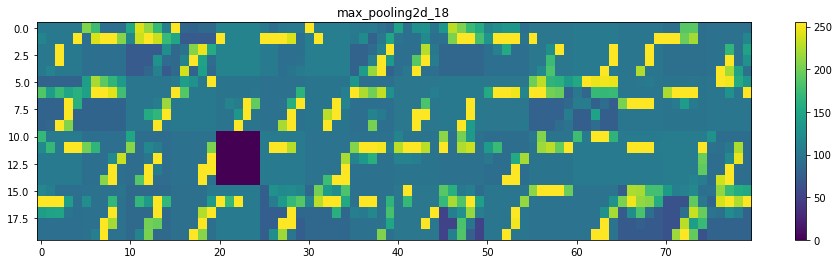

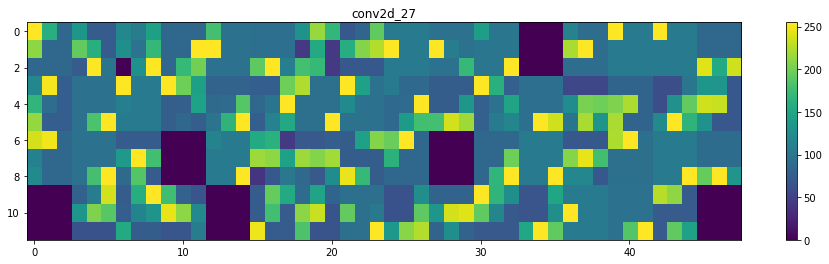

In [28]:
#initiate model
model = initiate_model()
#print the model to output file
print_model()
#create model
model = get_model(X_train_mixed, y_train_mixed_transformed)
#Save the model
model.save('models\X_train_mixed.h5')
#Get metrics result v
get_metrics(X_test_mixed, y_test_mixed, 'evaluation.X_train_mixed.X_test_mixed')
#Get metrics result vi
get_metrics(X_test_transformed, y_test, 'evaluation.X_train_mixed.X_test')
#Get metrics result vii
get_metrics(X_test_inverted_transformed, y_test, 'evaluation.X_train_mixed.X_test_inverted')

#export visualizations vi
visualize(0,X_test_transformed, 'X_test', 'X_train_mixed')
#export visualization vii
visualize(0,X_test_inverted_transformed, 'X_test_inverted', 'X_train_mixed')

# Extra visualizations

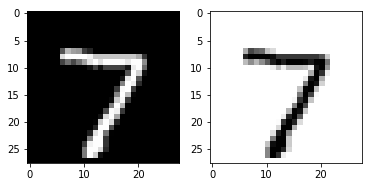

In [36]:
plot_images(0)